In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# What is a Stochastic Process?

A stochastic process is simply a sequence of random variables indexed by time. This is in contrast to cross-sectional data where there is no notion of order/sequence/time.


A single sample only gives you one time series path; however, since each observation is a random variable, there is a probability distribution that dictates the range of outcomes for all future paths.

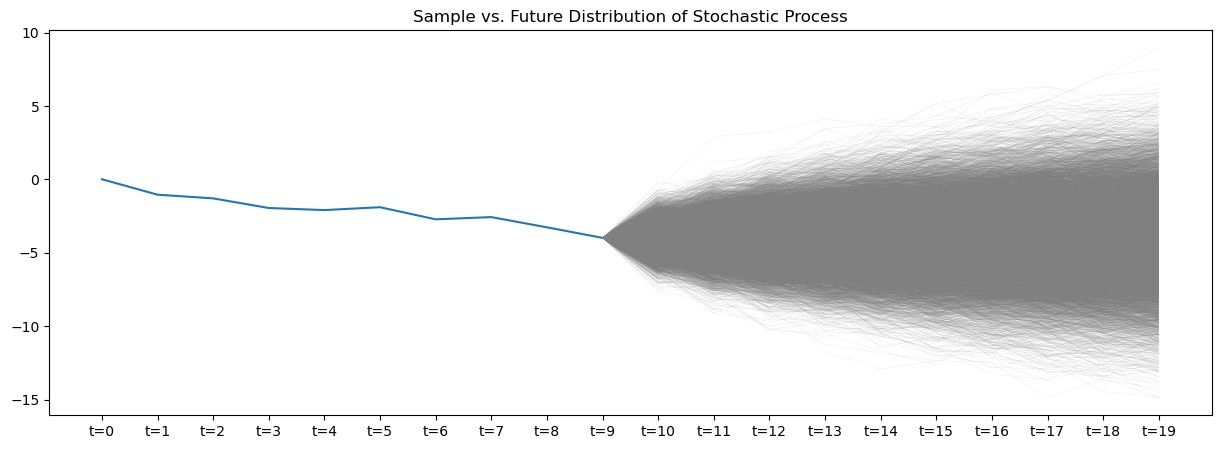

In [31]:
time_series_sample: pd.Series = pd.Series(np.random.standard_normal(size=10), index=np.arange(start=0, stop=10, step=1)).cumsum()
time_series_prediction: pd.DataFrame = pd.DataFrame(np.random.standard_normal(size=(11, 10_000)), index=np.arange(start=9, stop=20, step=1))
time_series_prediction.iloc[0] = time_series_sample.iloc[-1]
time_series_prediction = time_series_prediction.cumsum()

plt.figure(figsize=(15, 5))
plt.plot(time_series_sample)
plt.plot(time_series_prediction, color="grey", linewidth=0.05)
plt.title("Sample vs. Future Distribution of Stochastic Process")
plt.xticks(ticks=np.arange(start=0, stop=20, step=1), labels=[f"t={index}" for index in np.arange(start=0, stop=20, step=1)])
plt.show()

# How do we model stochastic processes?

Static Models:
- Capture instantaneous effects

$$
y_t = X_{exog, t} \mathbb{\beta_{exog, t}} + \epsilon_t
$$

Dynamic Models:
- Exogenous Variables: external variables that are not directly related to the stochastic process itself
- Endogenous Variables: internal variables that are dependent on the model itself (e.g., AR terms, MA terms, etc.) which, most often, capture intertemporal dynamics

$$
y_t = X_{exog, t} \mathbb{\beta_{exog, t}} + X_{endog, t} \mathbb{\beta_{endog, t}} + \epsilon_t
$$

$$
y_t = X_{exog, t} \mathbb{\beta_{exog, t}} + \epsilon_{t-1} \mathbb{\beta_{\epsilon_{t-1}}} + \mathbb{y_{t-1}} \mathbb{\beta_{y_{t-1}}} + \epsilon_t
$$

# What is stationarity?

Generally, there are three types of stationarity: 

Strict Stationarity
- All moments of the stochastic process are constant throughout time
- This is often difficult to guarantee

Weak Stationarity
- Mean and variance are constant throughout time
- This is traditionally what we're concerned with when testing for stationarity

Trend Stationary: 
- The first difference of the process follows weak stationarity
- The process itself is not stationary without transformations

# Why is stationarity important?

This ensures that a statistical model is sufficiently generalizable out-of-sample. Even if we dynamically update our model (e.g., on a rolling basis), we don't want our model to exhibit high variance. The model, although adaptive to new data, should be relatively stable throughout each re-fitting period. Otherwise, the reliability of the model is very low.   


In [569]:
def simulate_autoregressive_time_series(beta_ar_1: float, n: int = 500, plot: bool = False) -> pd.Series:

    mu: float = 0
    alpha: float = 0.00
    sigma: float = 1

    time_series: np.ndarray = np.empty(shape=n)

    for t in range(len(time_series)):

        e_t: float = np.random.normal(loc=0.0, scale=0.10 * sigma)

        if t == 0:
            time_series[t] = alpha + np.random.normal(loc=mu, scale=sigma) + e_t
        else:
            time_series[t] = alpha + beta_ar_1 * time_series[t-1] + e_t

    if plot:
        plt.plot(time_series)
        plt.title(f"Time Series: AR(1) Beta = {beta_ar_1}")
        plt.show()

        difference: pd.Series = pd.Series(time_series) - pd.Series(time_series).shift(1) 
        plt.plot(difference)
        plt.title("Time Series 1st Difference")
        plt.show()

    return pd.Series(time_series)

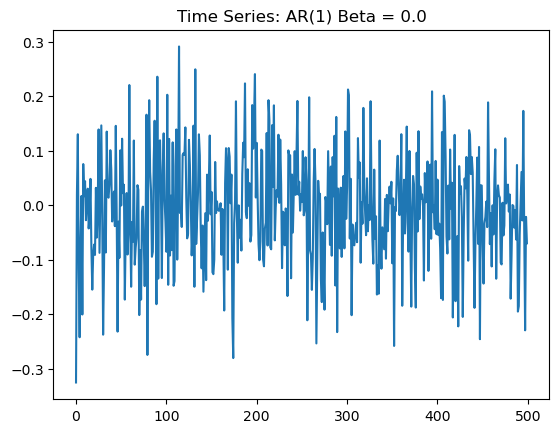

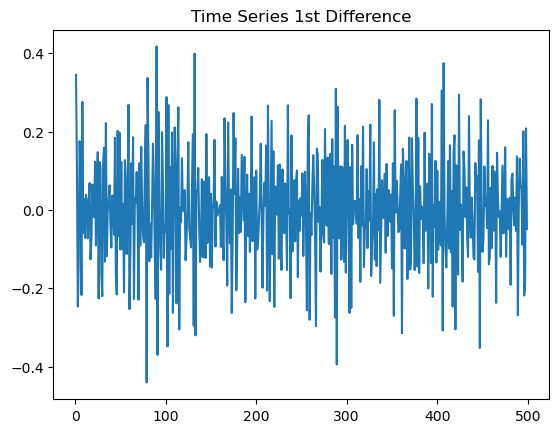

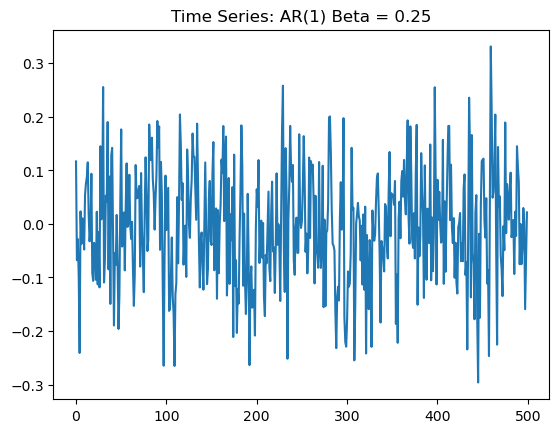

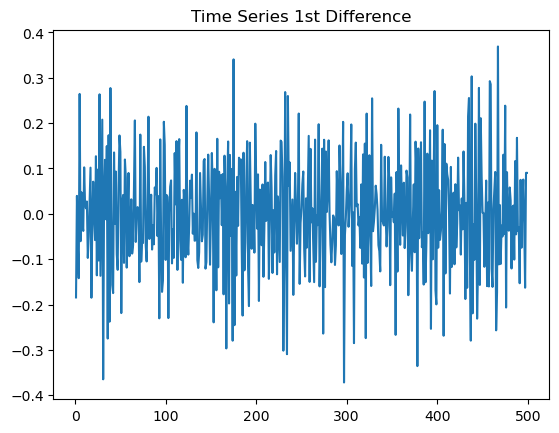

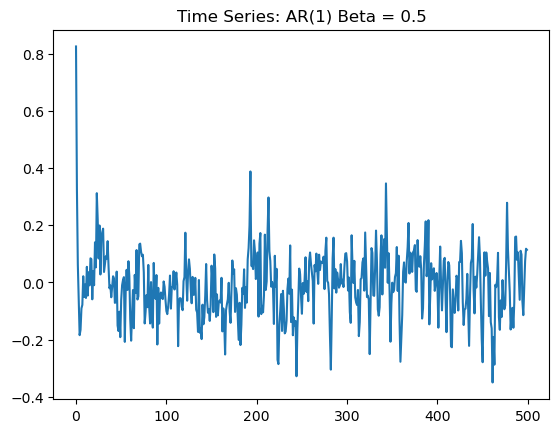

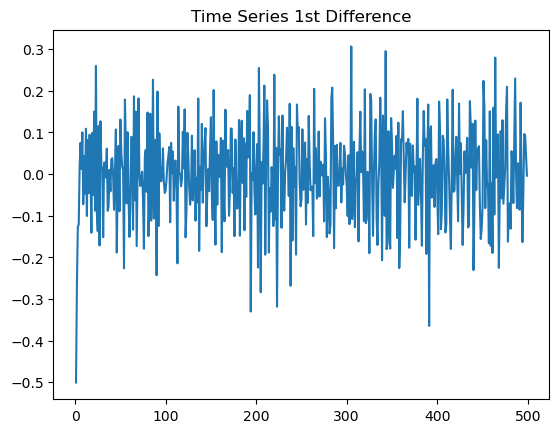

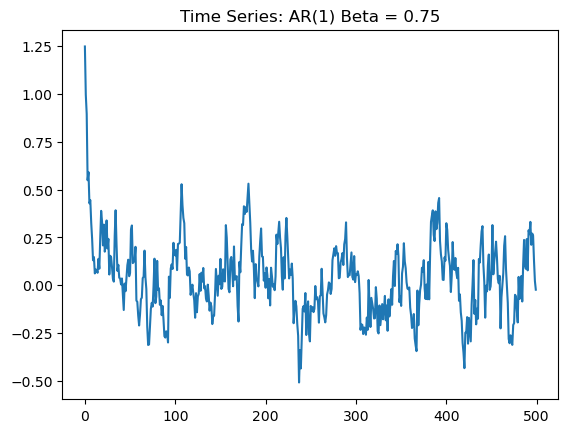

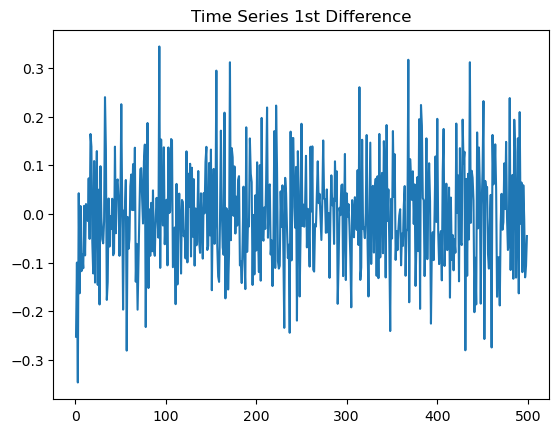

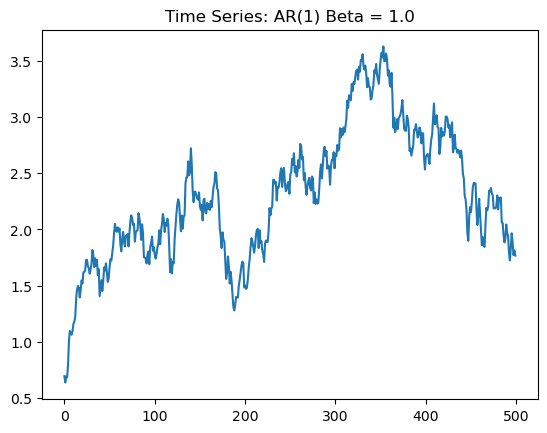

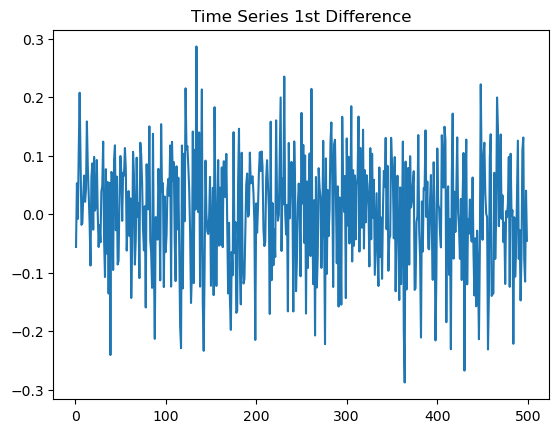

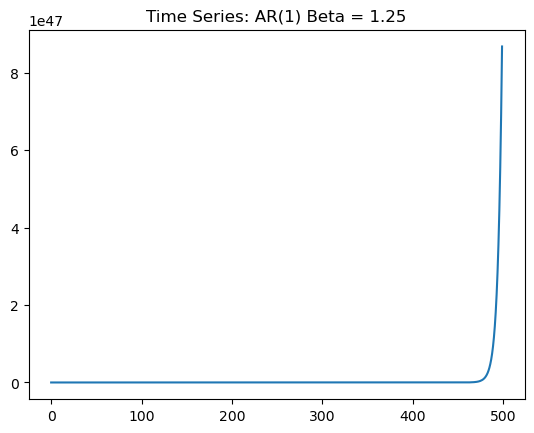

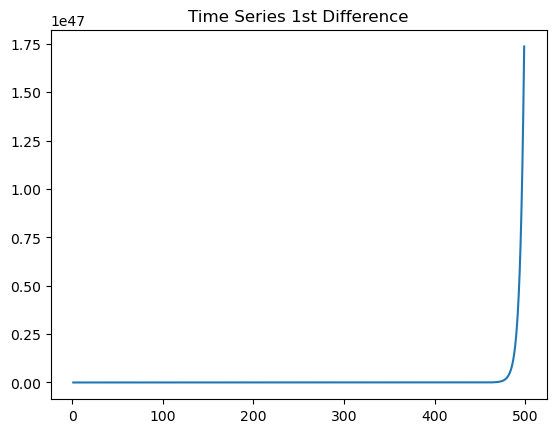

In [570]:
for beta_ar_1 in (0.0, 0.25, 0.50, 0.75, 1.00, 1.25):
    simulate_autoregressive_time_series(beta_ar_1=beta_ar_1, plot=True)

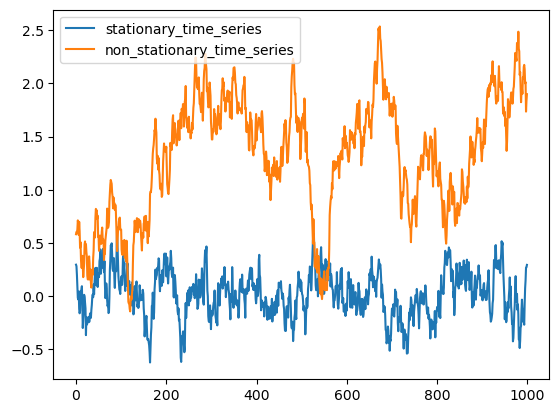

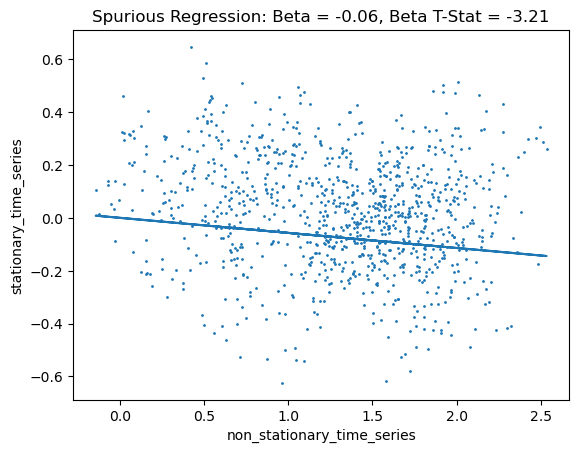

In [605]:
n: int = 1_000
data: pd.DataFrame = pd.DataFrame(
    {
        "stationary_time_series": simulate_autoregressive_time_series(beta_ar_1=0.90, n=n),
        "non_stationary_time_series": simulate_autoregressive_time_series(beta_ar_1=1.00, n=n)
    }
)

# Plot data
data.plot()
plt.show()

# Plot scatter, regression, and statistical significance
beta: float = data.cov().iloc[0, 1] / data["non_stationary_time_series"].var(ddof=1)
beta_t_stat: float = beta / (np.std(a=data["non_stationary_time_series"], ddof=1) / np.sqrt(n))
data.plot(kind="scatter", x="non_stationary_time_series", y="stationary_time_series", s=1)
y_hat: pd.Series = pd.Series({x: x * beta for x in data["non_stationary_time_series"]})
y_hat.plot()
plt.title(f"Spurious Regression: Beta = {beta.round(2)}, Beta T-Stat = {beta_t_stat.round(2)}")
plt.show()

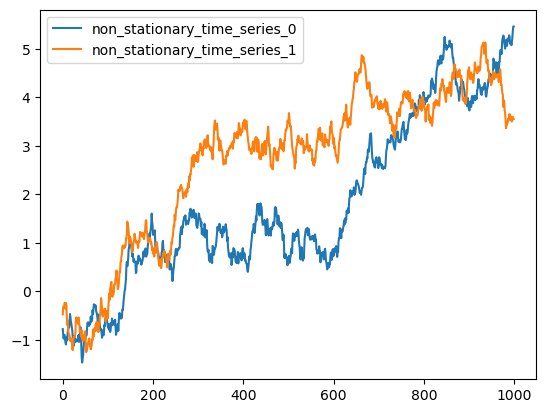

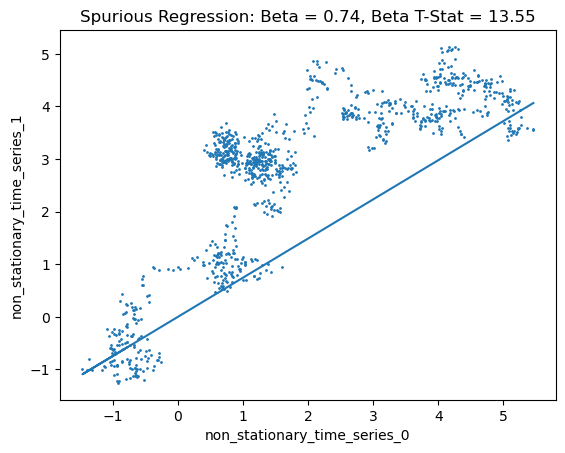

In [596]:
n: int = 1_000
data: pd.DataFrame = pd.DataFrame(
    {
        "non_stationary_time_series_0": simulate_autoregressive_time_series(beta_ar_1=1.0, n=n),
        "non_stationary_time_series_1": simulate_autoregressive_time_series(beta_ar_1=1.0, n=n) 
    }
)

# Plot data
data.plot()
plt.show()

# Plot scatter, regression, and statistical significance
beta: float = data.cov().iloc[0, 1] / data["non_stationary_time_series_0"].var(ddof=1)
beta_t_stat: float = beta / (np.std(a=data["non_stationary_time_series_0"], ddof=1) / np.sqrt(n))
data.plot(kind="scatter", x="non_stationary_time_series_0", y="non_stationary_time_series_1", s=1)
y_hat: pd.Series = pd.Series({x: x * beta for x in data["non_stationary_time_series_0"]})
y_hat.plot()
plt.title(f"Spurious Regression: Beta = {beta.round(2)}, Beta T-Stat = {beta_t_stat.round(2)}")
plt.show()

In [454]:
y_hat

-1.772562   -0.003982
-1.739869   -0.003909
-1.884793   -0.004234
-1.972223   -0.004431
-2.127237   -0.004779
               ...   
-3.765159   -0.008458
-3.724992   -0.008368
-3.738798   -0.008399
-3.814486   -0.008569
-3.801320   -0.008539
Length: 1000, dtype: float64

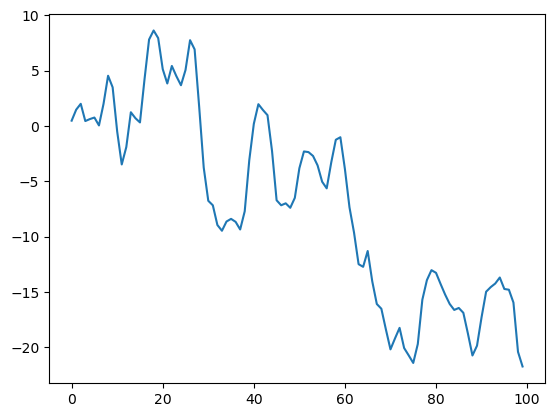

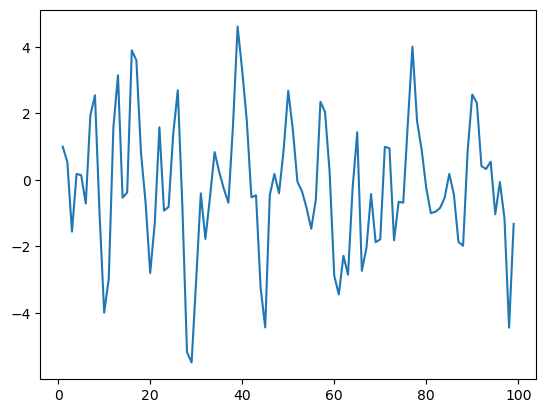

In [ ]:
# Make the process variance, but not mean stationary 
beta_ar_1: float = 1
sigma: np.ndarray = 1
mu: np.ndarray = np.random.standard_normal(size=100)
non_stationary_sample: np.ndarray = np.array([np.random.normal(loc=mu_t, scale=sigma) for mu_t in mu])

sample_time_series: np.ndarray = np.empty(shape=100)
for t, x_t in enumerate(non_stationary_sample):

    e_t: float = np.random.normal(loc=0.0, scale=0.10 * sigma)

    if t == 0:
        sample_time_series[t] = x_t + e_t
    else:
        sample_time_series[t] = sample_time_series[t-1] + x_t + non_stationary_sample[t-1] * beta_ar_1 + e_t

plt.plot(sample_time_series)
plt.show()

difference: pd.Series = pd.Series(sample_time_series) - pd.Series(sample_time_series).shift(1) 
plt.plot(difference)
plt.show()

In [237]:
difference.cov(difference.shift(1)) / difference.shift(1).var()

0.5231374014770037

In [238]:
pd.concat([difference, difference.shift(1)], axis=1).cov()

,0,1
0,4.034969,2.126016
1,2.126016,4.063973


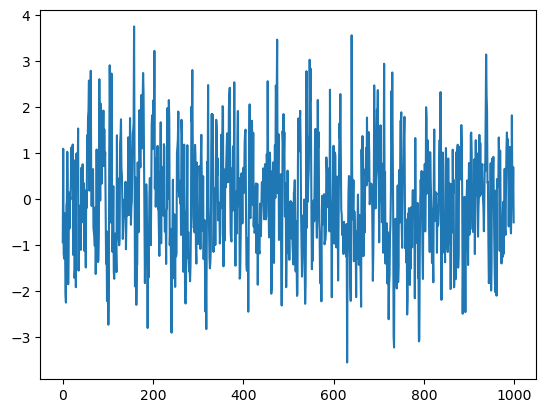

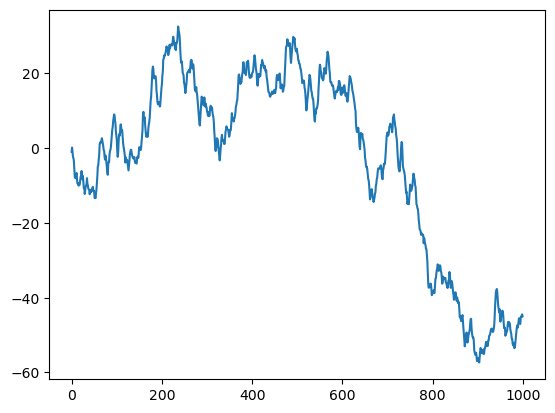

In [361]:
mu: float = 0
beta: float = 0.5
sigma: np.ndarray = 1
random_sample: np.ndarray = np.random.normal(loc=mu, scale=sigma, size=1000)

time_series: np.ndarray = np.empty(shape=1000)

for t, x_t in enumerate(random_sample):

    e_t: float = np.random.normal(loc=0.0, scale=0.10 * sigma)

    if t == 0:
        time_series[t] = x_t + e_t
    else:
        time_series[t] = x_t + time_series[t-1] * beta + e_t

plt.plot(time_series)
plt.show()

cumulative_time_series: np.ndarray = np.cumsum(time_series)
plt.plot(cumulative_time_series)
plt.show()

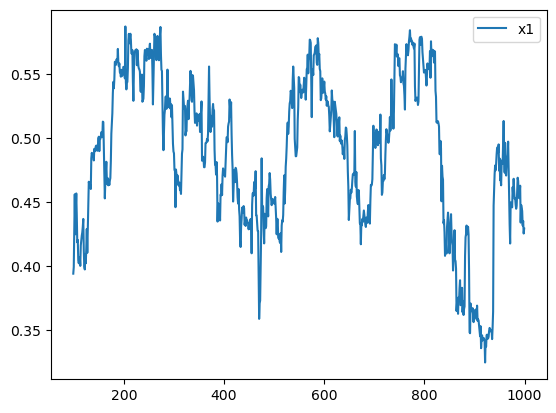

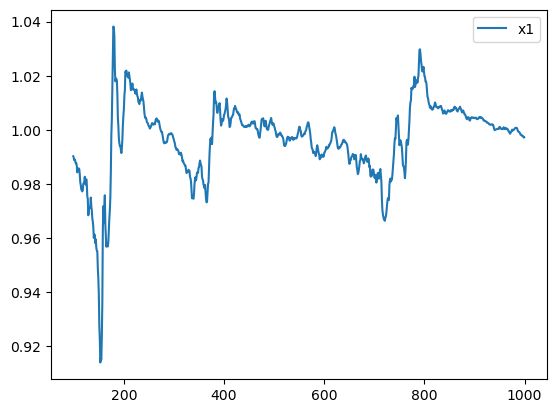

In [362]:
from statsmodels.regression.rolling import RollingOLS

model = RollingOLS(endog=pd.Series(time_series), exog=pd.Series(time_series).shift(1), window=100).fit()
model.params.plot()
plt.show()

model = RollingOLS(endog=pd.Series(cumulative_time_series), exog=pd.Series(cumulative_time_series).shift(1), window=100).fit()
model.params.plot()
plt.show()

Determine beta's sensitivity to each parameter being non-stationary... 